In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import warnings


In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.1 MB/s eta 0:00:00


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import optuna

с помощь optuna будем искать подходящие параметры для нахождения mortgage

[I 2025-04-06 07:58:46,812] A new study created in memory with name: no-name-f0aa3e39-52cb-468f-8937-0cb908525f10
[I 2025-04-06 07:59:01,451] Trial 0 finished with value: 0.7982171360549739 and parameters: {'lr': 1.6305610756231926e-05, 'batch_size': 256, 'optimizer': 'NAdam', 'weight_decay': 0.051188267782546815, 'n_layers': 4, 'activation': 'ReLU', 'n_units_0': 352, 'use_bn_0': False, 'dropout_0': 0.5522348854800401, 'n_units_1': 192, 'use_bn_1': True, 'dropout_1': 0.5587605886874115, 'n_units_2': 512, 'use_bn_2': True, 'dropout_2': 0.2192661229227232, 'n_units_3': 96, 'use_bn_3': True, 'dropout_3': 0.6648108232219854, 'epochs': 10, 'scheduler': 'CosineAnnealing'}. Best is trial 0 with value: 0.7982171360549739.
[I 2025-04-06 08:00:20,147] Trial 1 finished with value: 0.9179224269314359 and parameters: {'lr': 2.623598938754751e-06, 'batch_size': 16, 'optimizer': 'NAdam', 'weight_decay': 0.07441269939249393, 'n_layers': 5, 'activation': 'LeakyReLU', 'n_units_0': 240, 'use_bn_0': True,

Best trial:
  ROC AUC: 0.9411
  Params: 
    lr: 0.0009389762667843739
    batch_size: 128
    optimizer: Adam
    weight_decay: 0.016556341287653237
    n_layers: 1
    activation: LeakyReLU
    n_units_0: 288
    use_bn_0: False
    dropout_0: 0.09744583462030448
    epochs: 21
    scheduler: none


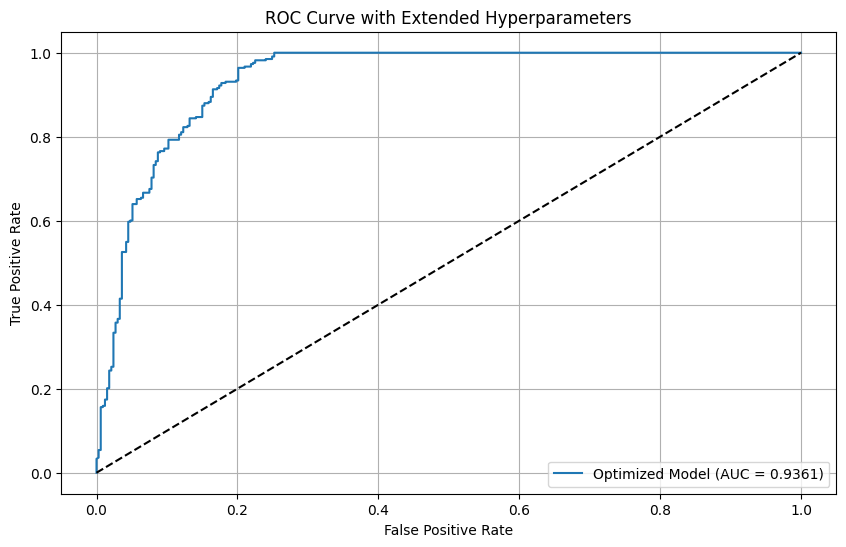

In [3]:
train_data = pd.read_csv('train_Mortgage.csv')
val_data = pd.read_csv('val_Mortgage.csv')

combined = pd.concat([train_data, val_data])
X = combined.drop('Mortgage', axis=1).values
y = combined['Mortgage'].values

X_train = X[:len(train_data)]
y_train = y[:len(train_data)]
X_val = X[len(train_data):]
y_val = y[len(train_data):]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

def create_model(trial, input_size):
    layers = []
    in_features = input_size

    n_layers = trial.suggest_int('n_layers', 1, 5)
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])

    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_{i}', 16, 512, step=16)
        layers.append(nn.Linear(in_features, out_features))

        if activation == 'ReLU':
            layers.append(nn.ReLU())
        elif activation == 'LeakyReLU':
            layers.append(nn.LeakyReLU(negative_slope=0.1))
        else:
            layers.append(nn.ELU())

        use_bn = trial.suggest_categorical(f'use_bn_{i}', [True, False])
        if use_bn:
            layers.append(nn.BatchNorm1d(out_features))

        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.7)
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        in_features = out_features

    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

def objective(trial):
    try:
        lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'NAdam', 'RAdam'])
        weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)

        model = create_model(trial, X_train.shape[1])

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'NAdam':
            optimizer = optim.NAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

        epochs = trial.suggest_int('epochs', 10, 30)
        scheduler_name = trial.suggest_categorical('scheduler', ['none', 'CosineAnnealing', 'ReduceLROnPlateau'])

        if scheduler_name == 'CosineAnnealing':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_name == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
        else:
            scheduler = None

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = nn.BCELoss()(outputs, labels)
                loss.backward()
                optimizer.step()

            if scheduler:
                if scheduler_name == 'ReduceLROnPlateau':
                    scheduler.step(loss)
                else:
                    scheduler.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor).numpy()
            roc_auc = roc_auc_score(y_val, y_pred)

        return roc_auc

    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        raise optuna.exceptions.TrialPruned()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

print("Best trial:")
trial = study.best_trial
print(f"  ROC AUC: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_params
final_model = create_model(study.best_trial, X_train.shape[1])

if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(final_model.parameters(),
                         lr=best_params['lr'],
                         weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'NAdam':
    optimizer = optim.NAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
else:
    optimizer = optim.RAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
for epoch in range(100):
    final_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = nn.BCELoss()(outputs, labels)
        loss.backward()
        optimizer.step()

final_model.eval()
with torch.no_grad():
    y_pred = final_model(X_val_tensor).numpy()
    roc_auc = roc_auc_score(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Optimized Model (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Extended Hyperparameters')
plt.legend()
plt.grid()
plt.show()
svm_for_mortgage = final_model

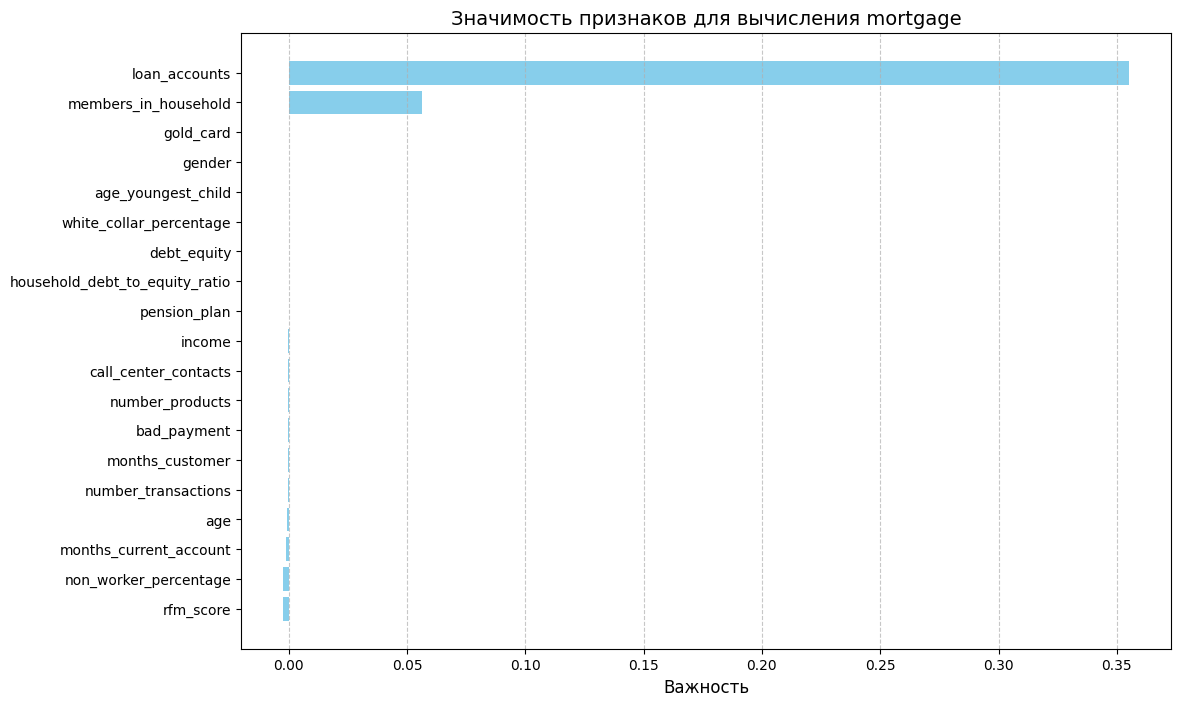

In [5]:
final_model.eval()
with torch.no_grad():
    y_pred = final_model(X_val_tensor).numpy()
    original_auc = roc_auc_score(y_val, y_pred)

feature_importance = np.zeros(X_val.shape[1])
for i in range(X_val.shape[1]):
    X_val_perturbed = X_val.copy()
    np.random.shuffle(X_val_perturbed[:, i])
    X_val_perturbed_tensor = torch.FloatTensor(X_val_perturbed)
    with torch.no_grad():
        y_pred_perturbed = final_model(X_val_perturbed_tensor).numpy()
        perturbed_auc = roc_auc_score(y_val, y_pred_perturbed)
    feature_importance[i] = original_auc - perturbed_auc

feature_names = combined.drop('Mortgage', axis=1).columns
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx], align='center', color='skyblue')
plt.yticks(range(len(feature_importance)), feature_names[sorted_idx])
plt.xlabel('Важность', fontsize=12)
plt.title('Значимость признаков для вычисления mortgage', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

теперь составим модель для Pension

In [7]:
import torch

[I 2025-04-06 16:08:42,653] A new study created in memory with name: no-name-0fc31456-af9a-4404-a506-3a87cbd6c406
[I 2025-04-06 16:09:16,259] Trial 0 finished with value: 0.5 and parameters: {'lr': 0.0017882476341227285, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 0.08451311334649503, 'n_layers': 3, 'activation': 'ReLU', 'n_units_0': 16, 'use_bn_0': False, 'dropout_0': 0.4996343878358791, 'n_units_1': 304, 'use_bn_1': True, 'dropout_1': 0.026278835750885597, 'n_units_2': 96, 'use_bn_2': False, 'dropout_2': 0.4649697008981193, 'epochs': 14, 'scheduler': 'ReduceLROnPlateau'}. Best is trial 0 with value: 0.5.
[I 2025-04-06 16:09:25,204] Trial 1 finished with value: 0.7740220092002272 and parameters: {'lr': 0.0004618851036653019, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 0.08220883003896644, 'n_layers': 4, 'activation': 'LeakyReLU', 'n_units_0': 96, 'use_bn_0': True, 'dropout_0': 0.47360782744372626, 'n_units_1': 416, 'use_bn_1': False, 'dropout_1': 0.3308836029867

Best trial:
  ROC AUC: 0.7793
  Params: 
    lr: 7.68535319522705e-05
    batch_size: 32
    optimizer: RAdam
    weight_decay: 0.053608857832928326
    n_layers: 5
    activation: ELU
    n_units_0: 416
    use_bn_0: False
    dropout_0: 0.6134466554387097
    n_units_1: 176
    use_bn_1: True
    dropout_1: 0.6174757563151918
    n_units_2: 320
    use_bn_2: True
    dropout_2: 0.20872149829905576
    n_units_3: 512
    use_bn_3: False
    dropout_3: 0.26399629573876554
    n_units_4: 352
    use_bn_4: True
    dropout_4: 0.006324226557647028
    epochs: 27
    scheduler: ReduceLROnPlateau


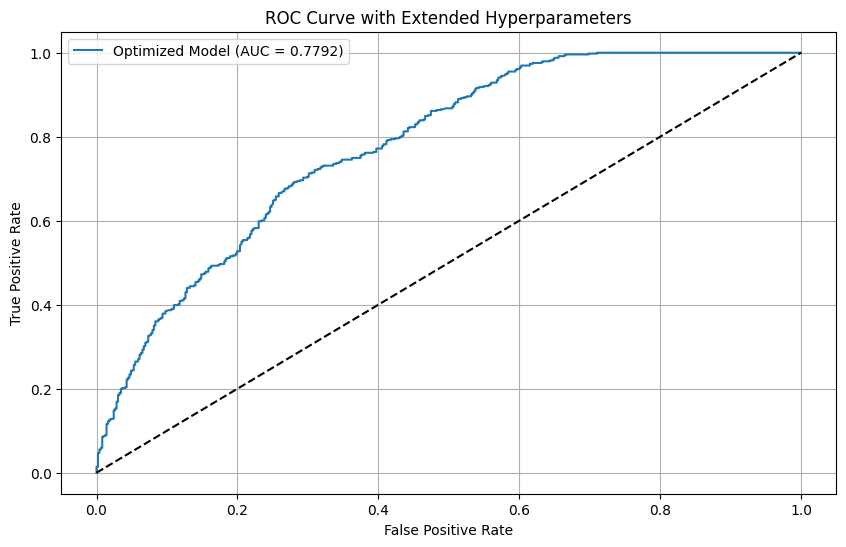

In [9]:
train_data = pd.read_csv('train_Pension.csv')
val_data = pd.read_csv('val_Pension.csv')

combined = pd.concat([train_data, val_data])
X = combined.drop('Pension', axis=1).values
y = combined['Pension'].values

X_train = X[:len(train_data)]
y_train = y[:len(train_data)]
X_val = X[len(train_data):]
y_val = y[len(train_data):]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

def create_model(trial, input_size):
    layers = []
    in_features = input_size

    n_layers = trial.suggest_int('n_layers', 1, 5)
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])

    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_{i}', 16, 512, step=16)
        layers.append(nn.Linear(in_features, out_features))

        if activation == 'ReLU':
            layers.append(nn.ReLU())
        elif activation == 'LeakyReLU':
            layers.append(nn.LeakyReLU(negative_slope=0.1))
        else:
            layers.append(nn.ELU())

        use_bn = trial.suggest_categorical(f'use_bn_{i}', [True, False])
        if use_bn:
            layers.append(nn.BatchNorm1d(out_features))

        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.7)
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        in_features = out_features

    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

def objective(trial):
    try:
        lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'NAdam', 'RAdam'])
        weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)

        model = create_model(trial, X_train.shape[1])

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'NAdam':
            optimizer = optim.NAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

        epochs = trial.suggest_int('epochs', 10, 30)
        scheduler_name = trial.suggest_categorical('scheduler', ['none', 'CosineAnnealing', 'ReduceLROnPlateau'])

        if scheduler_name == 'CosineAnnealing':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_name == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
        else:
            scheduler = None

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = nn.BCELoss()(outputs, labels)
                loss.backward()
                optimizer.step()

            if scheduler:
                if scheduler_name == 'ReduceLROnPlateau':
                    scheduler.step(loss)
                else:
                    scheduler.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor).numpy()
            roc_auc = roc_auc_score(y_val, y_pred)

        return roc_auc

    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        raise optuna.exceptions.TrialPruned()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

print("Best trial:")
trial = study.best_trial
print(f"  ROC AUC: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_params
final_model = create_model(study.best_trial, X_train.shape[1])

if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(final_model.parameters(),
                         lr=best_params['lr'],
                         weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'NAdam':
    optimizer = optim.NAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
else:
    optimizer = optim.RAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
for epoch in range(100):
    final_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = nn.BCELoss()(outputs, labels)
        loss.backward()
        optimizer.step()

final_model.eval()
with torch.no_grad():
    y_pred = final_model(X_val_tensor).numpy()
    roc_auc = roc_auc_score(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Optimized Model (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Extended Hyperparameters')
plt.legend()
plt.grid()
plt.show()
svm_for_Pension = final_model

теперь повторим для savings

[I 2025-04-06 10:01:58,277] A new study created in memory with name: no-name-cb7beec9-460d-4229-928d-2d0709bbf742
[I 2025-04-06 10:02:16,650] Trial 0 finished with value: 0.6962228213297854 and parameters: {'lr': 0.006669146411913567, 'batch_size': 64, 'optimizer': 'RAdam', 'weight_decay': 0.05011373214951649, 'n_layers': 3, 'activation': 'ELU', 'n_units_0': 272, 'use_bn_0': False, 'dropout_0': 0.026921864480329058, 'n_units_1': 288, 'use_bn_1': True, 'dropout_1': 0.21542423097954808, 'n_units_2': 256, 'use_bn_2': True, 'dropout_2': 0.28001756964790586, 'epochs': 17, 'scheduler': 'CosineAnnealing'}. Best is trial 0 with value: 0.6962228213297854.
[I 2025-04-06 10:02:25,784] Trial 1 finished with value: 0.6930576660481076 and parameters: {'lr': 0.0001518982506727928, 'batch_size': 64, 'optimizer': 'AdamW', 'weight_decay': 0.08521772173164877, 'n_layers': 2, 'activation': 'ReLU', 'n_units_0': 80, 'use_bn_0': False, 'dropout_0': 0.26201249429208806, 'n_units_1': 464, 'use_bn_1': False, 'd

Best trial:
  ROC AUC: 0.6997
  Params: 
    lr: 1.2885236139445882e-05
    batch_size: 256
    optimizer: RAdam
    weight_decay: 0.03358689934519892
    n_layers: 5
    activation: ELU
    n_units_0: 224
    use_bn_0: True
    dropout_0: 0.10032218517869763
    n_units_1: 96
    use_bn_1: False
    dropout_1: 0.32480061818437067
    n_units_2: 112
    use_bn_2: False
    dropout_2: 0.45442293982952187
    n_units_3: 224
    use_bn_3: True
    dropout_3: 0.4944814948894172
    n_units_4: 496
    use_bn_4: True
    dropout_4: 0.6560399174919826
    epochs: 30
    scheduler: none


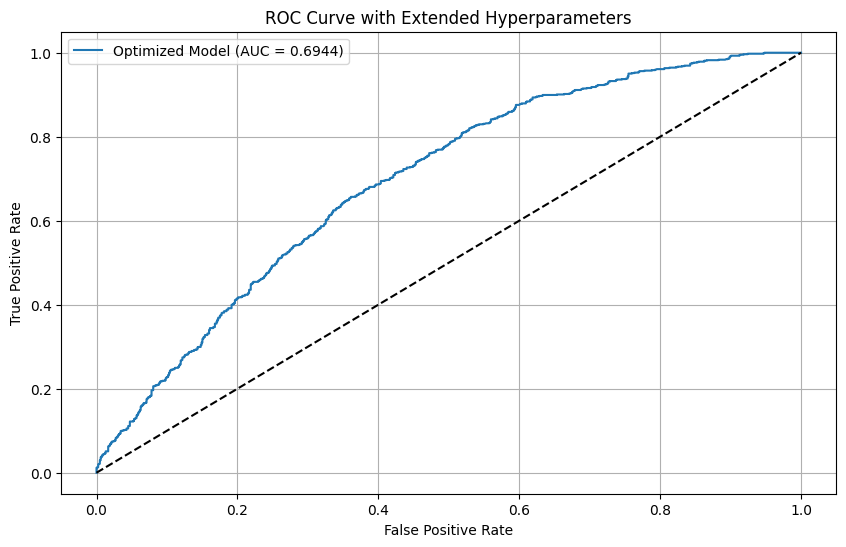

In [8]:
train_data = pd.read_csv('train_Savings.csv')
val_data = pd.read_csv('val_Savings.csv')

combined = pd.concat([train_data, val_data])
X = combined.drop('Savings', axis=1).values
y = combined['Savings'].values

X_train = X[:len(train_data)]
y_train = y[:len(train_data)]
X_val = X[len(train_data):]
y_val = y[len(train_data):]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

def create_model(trial, input_size):
    layers = []
    in_features = input_size

    n_layers = trial.suggest_int('n_layers', 1, 5)
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])

    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_{i}', 16, 512, step=16)
        layers.append(nn.Linear(in_features, out_features))

        if activation == 'ReLU':
            layers.append(nn.ReLU())
        elif activation == 'LeakyReLU':
            layers.append(nn.LeakyReLU(negative_slope=0.1))
        else:
            layers.append(nn.ELU())

        use_bn = trial.suggest_categorical(f'use_bn_{i}', [True, False])
        if use_bn:
            layers.append(nn.BatchNorm1d(out_features))

        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.7)
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        in_features = out_features

    layers.append(nn.Linear(in_features, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

def objective(trial):
    try:
        lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'NAdam', 'RAdam'])
        weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)

        model = create_model(trial, X_train.shape[1])

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'NAdam':
            optimizer = optim.NAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

        epochs = trial.suggest_int('epochs', 10, 30)
        scheduler_name = trial.suggest_categorical('scheduler', ['none', 'CosineAnnealing', 'ReduceLROnPlateau'])

        if scheduler_name == 'CosineAnnealing':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_name == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
        else:
            scheduler = None

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = nn.BCELoss()(outputs, labels)
                loss.backward()
                optimizer.step()

            if scheduler:
                if scheduler_name == 'ReduceLROnPlateau':
                    scheduler.step(loss)
                else:
                    scheduler.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor).numpy()
            roc_auc = roc_auc_score(y_val, y_pred)

        return roc_auc

    except Exception as e:
        print(f"Trial failed with error: {str(e)}")
        raise optuna.exceptions.TrialPruned()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

print("Best trial:")
trial = study.best_trial
print(f"  ROC AUC: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_params
final_model = create_model(study.best_trial, X_train.shape[1])

if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(final_model.parameters(),
                         lr=best_params['lr'],
                         weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'NAdam':
    optimizer = optim.NAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
else:
    optimizer = optim.RAdam(final_model.parameters(),
                          lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
for epoch in range(100):
    final_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = nn.BCELoss()(outputs, labels)
        loss.backward()
        optimizer.step()

final_model.eval()
with torch.no_grad():
    y_pred = final_model(X_val_tensor).numpy()
    roc_auc = roc_auc_score(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Optimized Model (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Extended Hyperparameters')
plt.legend()
plt.grid()
plt.show()
svm_for_Savings = final_model

резульаты полученных моделей несколько выше чем у других типов, но время обучения сильно больше